# H bond recognition and lifetime analysis

## $R(\text{D} \cdot \cdot \cdot \text{A}) - \angle \text{D} - \text{H} \cdot \cdot \cdot \text{A}$ heatmap

## Import packages

In [18]:
import json
from cage_data import cage1_info
from fishmol import trj, data
from fishmol.utils import retrieve_symbol

In [8]:
def find_d_a(atoms_dict):
    """
    Creat donor, acceptor dicts from atoms_dicts. Include one water to creat donor, acceptor for specified water.
    """
    donors = []
    acceptors = []
    for a_dict in atoms_dict:
        symbols = [retrieve_symbol(key) for key in list(a_dict.keys())] # retrieve chemical symbol from atoms_dict keys
        if symbols[0] == "F":
            acceptors += (a_dict,)
        elif symbols[0] == "N":
            if len(symbols) == 2:
                donors += (a_dict,)
            else:
                combs = [{"N": a_dict["N"], x: a_dict[x]} for x in list(a_dict.keys()) if x != "N"]
                donors += (combs[0], combs[1])

        elif symbols[0] == "O":
            if symbols[0] == symbols[1]:
                acceptors += (a_dict,)
            elif len(symbols) == 2 and symbols[0] != symbols[1]:
                donors += (a_dict,)
            else:
                combs = [{"O": a_dict["O"], x: a_dict[x]} for x in list(a_dict.keys()) if x != "O"]
                donors += (combs[0], combs[1])
                acceptors += ({"O": a_dict["O"]},)
    print(f"Done! {len(donors)} donors and {len(donors)} acceptors were found!\n" + "Acceptors:\n", acceptors, "\n Donors:\n", donors)
    return donors, acceptors

In [9]:
def pair_d_a(donors, acceptors):
    """
    Make d_a_pairs and d_h_a_pairs from the donors and acceptors dict.
    """
    d_a_pairs = []
    d_h_a_pairs = []
    for donor in donors:
        d_atom = [{x: donor[x]} for x in list(donor.keys()) if not x.startswith("H")]
        for acceptor in acceptors:
            keys = list(acceptor.keys())

            if len(keys) == 1:
                symbol = list(d_atom[0].keys())[0]
                if symbol == "O" and d_atom[0][symbol] == acceptor[keys[0]]: # exclude combinations where donor and acceptor are the same oxygen atom.
                    print(f"Donor and acceptor is the same atom: {symbol} {acceptor[keys[0]]}, skipped.")
                    continue
                else:
                    d_a_pairs += [[d_atom[0], acceptor],]
                    d_h_a_pairs += [[donor, acceptor],]
            else:
                for key in keys:
                    d_a_pairs += [[d_atom[0], {key: acceptor[key]}],]
                    d_h_a_pairs += [[donor, {key: acceptor[key]}],]
    print(f"Unique donoar-acceptor/donoar-hydrogen-acceptor combinations: {len(d_a_pairs)}")
    print(f"Sample donor-acceptor pair: {d_a_pairs[0]}\nSample donor-hydrogen-acceptor pair: {d_h_a_pairs[0]}")
    return d_a_pairs, d_h_a_pairs

In [31]:
def res_h(d_a_pairs, d_h_a_pairs, frames, water_d = None, water_a = None):
    """
    Calculates the H-bond information in each frame of the trajectory.
    """
    results = []
    if water_d != None:
        for i, frame in enumerate(frames):
            hbonds = [] #list to store all hbonds in current frame
            for d_a_pair, d_h_a_pair in zip(d_a_pairs, d_h_a_pairs):
                # Keep water participated H-bonds only
                if d_h_a_pair[0] in water_d or d_h_a_pair[1] in water_a:
                    # Sum of van der Waals radii
                    symbols = [list(item.keys()) for item in d_a_pair]
                    symbols = [item for sublist in symbols for item in sublist] # flatten the list of lists
                    symbols = [retrieve_symbol(symbol) for symbol in symbols] # Remove numbers and get chemical symbol from atoms_dict to be ready to pass to the vdW radii dict
                    vdW_sum = data.vdW_R[symbols[0]] + data.vdW_R[symbols[1]]

                    # not a H-bond of D-A distance is greater than their vdW radii times 1.05, 1.05 to take bond length change during MD simulation.
                    r_d_a = distance(d_a_pair, frame)  # calculate the D-A distance
                    if r_d_a <= 1.02 * vdW_sum:
                        # calculate the D-H⋅⋅⋅A angle
                        d_h_a_ang = frame.angle(*d_h_a_pair, mic = True)  # D-H···A angle               
                        d_h = distance([d_h_a_pair[0],], frame) # calculate the D-H length

                        # the D-H⋅⋅⋅A angle criteria used: the D-H⋅⋅⋅A angle is close to a right angle refer to the D-H⋅⋅⋅A angle - R(D⋅⋅⋅A) plot
                        # an angle range is included considering the oscillation of bond lenghth and anlgle
                        if d_h_a_ang >= (np.rad2deg(np.arctan2(r_d_a, d_h)) + 180)*3/8:
                        # if d_h_a_ang >= 90:
                            # Store current H-bond
                            hbonds.append(
                                  {
                                      "donor": d_h_a_pair[0],
                                      "acceptor": d_h_a_pair[1],
                                      "R(D-A)": r_d_a,
                                      "DHA_ang": d_h_a_ang,
                                      "r(D-H)": d_h,
                                  }
                            )

            results.append({f"frame": i, "n_hbonds": len(hbonds), "hbonds": hbonds})
            
    else:
        for i, frame in enumerate(frames):
            hbonds = [] #list to store all hbonds in current frame
            for d_a_pair, d_h_a_pair in zip(d_a_pairs, d_h_a_pairs):
                # Sum of van der Waals radii
                symbols = [list(item.keys()) for item in d_a_pair]
                symbols = [item for sublist in symbols for item in sublist] # flatten the list of lists
                symbols = [retrieve_symbol(symbol) for symbol in symbols] # Remove numbers and get chemical symbol from atoms_dict to be ready to pass to the vdW radii dict
                vdW_sum = data.vdW_R[symbols[0]] + data.vdW_R[symbols[1]]

                # not a H-bond of D-A distance is greater than their vdW radii times 1.02, 1.02 to take bond length change during MD simulation.
                r_d_a = frame.dist(*d_a_pair[0].values(), *d_a_pair[1].values(), mic = True) # calculate the D-A distance
                if r_d_a <= 1.02 * vdW_sum:
                    # calculate the D-H⋅⋅⋅A angle
                    d_h_a_ang = frame.angle(*d_h_a_pair[0].values(), *d_h_a_pair[1].values(), mic = True)  # D-H···A angle               
                    d_h = frame.dist(*d_h_a_pair[0].values(), mic = True) # calculate the D-H length

                    # the D-H⋅⋅⋅A angle criteria used: the D-H⋅⋅⋅A angle is close to a right angle refer to the D-H⋅⋅⋅A angle - R(D⋅⋅⋅A) plot
                    # an angle range is included considering the oscillation of bond lenghth and anlgle
                    if d_h_a_ang >= (np.rad2deg(np.arctan2(r_d_a, d_h)) + 180)*3/8:
                    # if d_h_a_ang >= 90:
                        # Store current H-bond
                        hbonds.append(
                                {
                                    "donor": d_h_a_pair[0],
                                    "acceptor": d_h_a_pair[1],
                                    "R(D-A)": r_d_a,
                                    "DHA_ang": d_h_a_ang,
                                    "r(D-H)": d_h,
                                }
                        )

            results.append({f"frame": i, "n_hbonds": len(hbonds), "hbonds": hbonds})
    return results

In [26]:
d_a_pairs[0]

[{'O': 14}, {'O': 17}]

In [3]:
def pop_C(TFAs):
    for TFA in TFAs:
        [TFA.pop(key) for key in list(TFA.keys()) if key == "C1" or key == "C2"] # keep F and O in TFAs only for H-bond analysis
    return TFAs

In [4]:
waters = cage1_info.waters
TFAs = cage1_info.TFAs
phenols = cage1_info.phenols
amines = cage1_info.amines
TFA_F_Os = pop_C(TFAs)
atoms_dict = waters + phenols + amines + TFA_F_Os
cell = cage1_info.cell

In [10]:
donors, acceptors = find_d_a(atoms_dict = atoms_dict)
d_a_pairs, d_h_a_pairs = pair_d_a(donors = donors, acceptors = acceptors)

Done! 40 donors and 40 acceptors were found!
Acceptors:
 [{'O': 14}, {'O': 17}, {'O': 143}, {'O': 146}, {'O': 272}, {'O': 275}, {'O': 401}, {'O': 404}, {'F1': 0, 'F2': 1, 'F3': 2, 'O1': 3, 'O2': 4}, {'F1': 7, 'F2': 8, 'F3': 9, 'O1': 10, 'O2': 11}, {'F1': 129, 'F2': 130, 'F3': 131, 'O1': 132, 'O2': 133}, {'F1': 136, 'F2': 137, 'F3': 138, 'O1': 139, 'O2': 140}, {'F1': 258, 'F2': 259, 'F3': 260, 'O1': 261, 'O2': 262}, {'F1': 265, 'F2': 266, 'F3': 267, 'O1': 268, 'O2': 269}, {'F1': 387, 'F2': 388, 'F3': 389, 'O1': 390, 'O2': 391}, {'F1': 394, 'F2': 395, 'F3': 396, 'O1': 397, 'O2': 398}] 
 Donors:
 [{'O': 14, 'H1': 15}, {'O': 14, 'H2': 16}, {'O': 17, 'H1': 18}, {'O': 17, 'H2': 19}, {'O': 143, 'H1': 144}, {'O': 143, 'H2': 145}, {'O': 146, 'H1': 147}, {'O': 146, 'H2': 148}, {'O': 272, 'H1': 273}, {'O': 272, 'H2': 274}, {'O': 275, 'H1': 276}, {'O': 275, 'H2': 277}, {'O': 401, 'H1': 402}, {'O': 401, 'H2': 403}, {'O': 404, 'H1': 405}, {'O': 404, 'H2': 406}, {'O': 24, 'H': 25}, {'O': 411, 'H': 41

In [33]:
import numpy as np

In [36]:
%%time
traj = trj.Trajectory(timestep = 5, data = "/nobackup/rhtp48/data_ana/cage1-500K.xyz", index = ":", cell = cell)

CPU times: user 2min 12s, sys: 3.19 s, total: 2min 15s
Wall time: 2min 16s


In [37]:
traj.wrap2box()

In [38]:
%%time
hbonds = res_h(d_a_pairs = d_a_pairs, d_h_a_pairs = d_h_a_pairs, frames = traj.frames)

CPU times: user 3h 38min 2s, sys: 3h 59min 28s, total: 7h 37min 30s
Wall time: 2h 35min 1s


In [39]:
with open("/nobackup/rhtp48/data_ana/results/cage1-hbonds-500K.json", "w") as json_file:
    json.dump(hbonds, json_file)
json_file.close()

### All H bonds

In [40]:
# import json
# # Opening JSON file
# f = open('results/cage1/nvt-500K/hbonds_500K.json')
 
# # returns JSON object as a dictionary
# hbonds = json.load(f)
 
# Iterating through the json list
nhbonds=[]
d_h_a_ang = []
r_d_a = []
for hbond in hbonds:
    nhbonds.append(hbond["n_hbonds"])
    a = hbond["hbonds"]
    for element in a:
        r_d_a.append(element["R(D-A)"])
        d_h_a_ang.append(element["DHA_ang"])

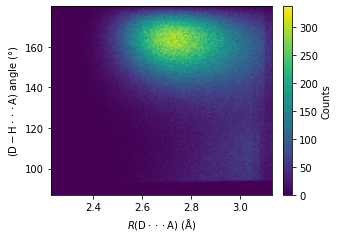

In [43]:
import matplotlib.pyplot as plt
_, ax =plt.subplots(figsize = (4.6, 3.2), constrained_layout =  True)
heatmap, xedges, yedges = np.histogram2d(np.array(r_d_a, dtype = float), np.array(d_h_a_ang, dtype = float), bins=150)

extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

im = ax.imshow(heatmap.T, extent=extent, origin='lower', aspect = "auto")
cbar = ax.figure.colorbar(im, ax = ax)
cbar.ax.set_ylabel("Counts", rotation=90, labelpad = 8.5, va="center", ha ="center")
ax.set_xlabel("$R\mathrm{(D\cdot \cdot \cdot A)}$ ($\mathrm{\AA}$)")
ax.set_ylabel("$\mathrm{(D-H\cdot \cdot \cdot A)}$ angle (°)")

plt.savefig("test/cage1-all_hbonds_angle_r_heatmap.jpg", dpi = 600)

plt.show()

### H bonds with the participance of water molecules